# Main Code


In [43]:
"""
trade_network_resilience.py  –  fast eff_w edition
==================================================

• 仅计算加权全局效率 (eff_w)
• 预计算 Floyd–Warshall 距离矩阵，大幅降低删点重算开销
• 生成:  ① 节点冲击热图 ② 年度鲁棒性曲线 ③ AUC 趋势折线
"""

from __future__ import annotations
from pathlib import Path
from typing import Dict, List

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl


# ───────────────────────────────────────────────────────────────────────────
# CONFIG                                                                     
# ───────────────────────────────────────────────────────────────────────────
DATA_SOURCE   = "E:\Obsidian\Project\专业课\大三下\Intro to Networks\Final_Essay\IMF_IMTS_Exports_1948_2024.csv"  # or dir of CSVs
COORD_CSV     = "E:\Obsidian\Project\专业课\大三下\Intro to Networks\Final_Essay\iso3_to_latlon.csv"
YEAR_START    = 1970
YEAR_END      = 2024
IMPACT_TOP_N  = 30
THRESHOLD     = None
OUTPUT_DIR    = Path("outputs"); OUTPUT_DIR.mkdir(exist_ok=True)

# ──── user-tunable display settings ────────────────────────────────────────
HEATMAP_MODE  = "quantile"       # "quantile" | "row_norm" | "rank"
GAMMA         = 0.4
Q_LOW, Q_HIGH = .05, .95
TOP_K_NODES   = 20
COLORMAP      = "Reds"


# ───────────────────────────────────────────────────────────────────────────
# 0. Coordinates                                                             
# ───────────────────────────────────────────────────────────────────────────
def _load_coord_dict(fp: str | Path) -> Dict[str, tuple[float, float]]:
    df = pd.read_csv(fp)
    return {r.ISO3: (r.Lat, r.Lon)
            for _, r in df.iterrows()
            if pd.notna(r.Lat) and pd.notna(r.Lon)}

COORD      = _load_coord_dict(COORD_CSV)
ISO_VALID  = set(COORD.keys())

# ───────────────────────────────────────────────────────────────────────────
# 1. Graph loader                                                            
# ───────────────────────────────────────────────────────────────────────────
def load_trade_graph(year: int,
                     src: Path | str,
                     threshold: float | None = None) -> nx.Graph:
    """Return weighted undirected trade graph for one year."""
    src = Path(src)
    if src.is_dir():
        df = (pd.read_csv(src / f"exports_{year}.csv")
                .rename(columns={"exporter": "u",
                                 "importer": "v",
                                 "value":    "w"}))
    else:
        raw = pd.read_csv(src, low_memory=False)
        if str(year) not in raw.columns:
            raise ValueError(f"{year} not in {src.name}")
        df = raw.loc[:, ["COUNTRY.ID", "COUNTERPART_COUNTRY.ID", str(year)]]
        df.columns = ["u", "v", "w"]

    df = (df.dropna(subset=["w"])
            .query("w>0 and u!=v")
            .loc[lambda x: x.u.isin(ISO_VALID) & x.v.isin(ISO_VALID)])
    if threshold is not None:
        df = df.query("w >= @threshold")

    G = nx.Graph()
    for u, v, w in df.itertuples(index=False):
        if G.has_edge(u, v):
            G[u][v]["weight"] += w
        else:
            G.add_edge(u, v, weight=w)
    return G
# ─── 2. 距离矩阵 & 效率计算 ────────────────────────────────────────────────
def distance_matrix(G: nx.Graph) -> tuple[np.ndarray, list]:
    """返回 Floyd-Warshall 最短距离矩阵 (1/weight) 及节点顺序列表。"""
    W = nx.to_numpy_array(G, weight="weight", dtype=float)
    W[W == 0] = np.inf
    D = 1 / W
    np.fill_diagonal(D, 0)
    dist = nx.floyd_warshall_numpy(nx.from_numpy_array(D))
    return dist, list(G)

def efficiency_from_mask(dist: np.ndarray, mask: np.ndarray) -> float:
    """给定距阵 dist 和保留节点布尔 mask，返回加权全局效率。"""
    sub = dist[np.ix_(mask, mask)]
    with np.errstate(divide='ignore'):
        inv = 1.0 / sub
    np.fill_diagonal(inv, 0)
    n = sub.shape[0]
    return np.sum(inv) / (n*(n-1)) if n > 1 else 0.0

# ─── 3. 单节点冲击 (矩阵版) ────────────────────────────────────────────────
def single_node_impact_fast(G: nx.Graph,
                            top_n: int = IMPACT_TOP_N) -> Dict[str, float]:
    dist, nodes = distance_matrix(G)
    n_total     = len(nodes)
    mask_all    = np.ones(n_total, dtype=bool)
    base_eff    = efficiency_from_mask(dist, mask_all)

    # 前 top_n 按加权度排序
    deg = {n: G.degree(n, weight="weight") for n in nodes}
    top_nodes = sorted(nodes, key=deg.get, reverse=True)[:top_n]

    impacts = {}
    for node in top_nodes:
        idx        = nodes.index(node)
        mask       = mask_all.copy();  mask[idx] = False
        new_eff    = efficiency_from_mask(dist, mask)
        impacts[node] = (base_eff - new_eff) / base_eff
    return impacts

# ─── 4. 鲁棒性曲线 (矩阵版) ────────────────────────────────────────────────
def robustness_curve_fast(G: nx.Graph) -> pd.DataFrame:
    dist, nodes = distance_matrix(G)
    strength    = {n: G.degree(n, weight="weight") for n in nodes}
    nodes_sorted = sorted(nodes, key=strength.get, reverse=True)

    mask = np.ones(len(nodes), dtype=bool)
    base = efficiency_from_mask(dist, mask)
    curve = []
    for i, node in enumerate(nodes_sorted, 1):
        mask[nodes.index(node)] = False
        val = efficiency_from_mask(dist, mask) if mask.sum() > 1 else 0.0
        curve.append({"removed_frac": i/len(nodes), "metric": val/base})
    return pd.DataFrame(curve)

auc = lambda df: np.trapz(df.metric, df.removed_frac)

# ─── 5. 可视化 ────────────────────────────────────────────────────────────
def plot_heatmap(df_imp: pd.DataFrame):
    pivot = (df_imp
             .groupby("year").apply(lambda g: g.nlargest(TOP_K_NODES, "impact"))
             .droplevel(0)
             .pivot(index="year", columns="country", values="impact")
             .fillna(0))

    plt.figure(figsize=(13,6))
    mode = HEATMAP_MODE.lower()

    if mode == "rank":
        rank  = pivot.rank(axis=1, method="min", ascending=False).fillna(TOP_K_NODES+1)
        bins, labels = [1,2,3,4,5,TOP_K_NODES+1], [5,4,3,2,1]
        data  = rank.apply(lambda r: pd.cut(r, bins=bins, labels=labels,
                                            right=False).astype(float), axis=1).fillna(0)/5
        cmap  = mpl.cm.get_cmap(COLORMAP, 5)
        norm  = mpl.colors.Normalize(vmin=0, vmax=1)
    else:   # row_norm / quantile (略去 row_norm 细节)
        data = pivot
        vmin, vmax = np.quantile(data.values, Q_LOW), np.quantile(data.values, Q_HIGH)
        norm = mpl.colors.PowerNorm(gamma=GAMMA, vmin=vmin, vmax=vmax)
        cmap = COLORMAP

    sns.heatmap(data, cmap=cmap, norm=norm, linecolor="0.9", linewidths=.4,
                cbar_kws={"label":"eff_w impact"})
    plt.title("Weighted efficiency impact heat-map")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR/"heatmap_eff_w.png", dpi=300)
    plt.close()
    print("[✓] heatmap saved")

def plot_curve(df: pd.DataFrame, year: int):
    plt.figure()
    plt.plot(df.removed_frac, df.metric, lw=2)
    plt.ylim(0,1.02); plt.grid(ls="--", alpha=.4)
    plt.title(f"Robustness curve eff_w – {year}")
    plt.xlabel("fraction removed"); plt.ylabel("metric/base")
    plt.tight_layout()
    plt.close()

def plot_auc_trend(df_auc: pd.DataFrame):
    plt.figure(figsize=(6,4))
    sns.lineplot(df_auc, x="year", y="auc", marker="o")
    plt.ylabel("AUC (↑ = more robust)")
    plt.title("Yearly robustness (AUC) – eff_w")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR/"auc_trend_eff_w.png", dpi=300)
    plt.close()
    print("[✓] trend plot saved")

# ─── 6. 主流程 ────────────────────────────────────────────────────────────
def run_pipeline():
    years = range(YEAR_START, YEAR_END+1)

    # ① 单节点冲击热图
    impact_rows = []
    for y in years:
        G = load_trade_graph(y, DATA_SOURCE)
        imp = single_node_impact_fast(G, IMPACT_TOP_N)
        impact_rows += [{"year": y, "country": c, "impact": v} for c, v in imp.items()]
    df_imp = pd.DataFrame(impact_rows)
    df_imp.to_csv(OUTPUT_DIR/"node_impacts_eff_w_fast.csv", index=False)
    plot_heatmap(df_imp)

    # ② 鲁棒性 & AUC 趋势
    auc_rows = []
    for y in years:
        G     = load_trade_graph(y, DATA_SOURCE)
        curve = robustness_curve_fast(G)
        plot_curve(curve, y)
        auc_rows.append({"year": y, "auc": auc(curve)})
    df_auc = pd.DataFrame(auc_rows)
    df_auc.to_csv(OUTPUT_DIR/"auc_eff_w_fast.csv", index=False)
    plot_auc_trend(df_auc)

if __name__ == "__main__":
    run_pipeline()


<>:25: SyntaxWarning: invalid escape sequence '\O'
<>:26: SyntaxWarning: invalid escape sequence '\O'
<>:25: SyntaxWarning: invalid escape sequence '\O'
<>:26: SyntaxWarning: invalid escape sequence '\O'
C:\Users\12693\AppData\Local\Temp\ipykernel_37320\2614593741.py:25: SyntaxWarning: invalid escape sequence '\O'
  DATA_SOURCE   = "E:\Obsidian\Project\专业课\大三下\Intro to Networks\Final_Essay\IMF_IMTS_Exports_1948_2024.csv"  # or dir of CSVs
C:\Users\12693\AppData\Local\Temp\ipykernel_37320\2614593741.py:26: SyntaxWarning: invalid escape sequence '\O'
  COORD_CSV     = "E:\Obsidian\Project\专业课\大三下\Intro to Networks\Final_Essay\iso3_to_latlon.csv"
C:\Users\12693\AppData\Local\Temp\ipykernel_37320\2614593741.py:145: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

[✓] heatmap saved


C:\Users\12693\AppData\Local\Temp\ipykernel_37320\2614593741.py:140: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lambda df: np.trapz(df.metric, df.removed_frac)
C:\Users\12693\AppData\Local\Temp\ipykernel_37320\2614593741.py:140: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lambda df: np.trapz(df.metric, df.removed_frac)
C:\Users\12693\AppData\Local\Temp\ipykernel_37320\2614593741.py:140: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lambda df: np.trapz(df.metric, df.removed_frac)
C:\Users\12693\AppData\Local\Temp\ipykernel_37320\2614593741.py:140: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lamb

[✓] trend plot saved


C:\Users\12693\AppData\Local\Temp\ipykernel_37320\2614593741.py:140: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lambda df: np.trapz(df.metric, df.removed_frac)


In [5]:
"""
trade_network_resilience.py  –  fast eff_w edition
==================================================

• 仅计算加权全局效率 (eff_w)
• 预计算 Floyd–Warshall 距离矩阵，大幅降低删点重算开销
• 生成:  ① 节点冲击热图 ② 年度鲁棒性曲线 ③ AUC 趋势折线
"""

from __future__ import annotations
from pathlib import Path
from typing import Dict, List

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl


# ───────────────────────────────────────────────────────────────────────────
# CONFIG                                                                     
# ───────────────────────────────────────────────────────────────────────────
DATA_SOURCE   = "E:\Obsidian\Project\专业课\大三下\Intro to Networks\Final_Essay\IMF_IMTS_Exports_1948_2024.csv"  # or dir of CSVs
COORD_CSV     = "E:\Obsidian\Project\专业课\大三下\Intro to Networks\Final_Essay\iso3_to_latlon.csv"
YEAR_START    = 1948
YEAR_END      = 2024
IMPACT_TOP_N  = 30
THRESHOLD     = None
OUTPUT_DIR    = Path("outputs"); OUTPUT_DIR.mkdir(exist_ok=True)

# ──── user-tunable display settings ────────────────────────────────────────
HEATMAP_MODE  = "quantile"       # "quantile" | "row_norm" | "rank"
GAMMA         = 0.4
Q_LOW, Q_HIGH = .05, .95
TOP_K_NODES   = 20
COLORMAP      = "Reds"


# ───────────────────────────────────────────────────────────────────────────
# 0. Coordinates                                                             
# ───────────────────────────────────────────────────────────────────────────
def _load_coord_dict(fp: str | Path) -> Dict[str, tuple[float, float]]:
    df = pd.read_csv(fp)
    return {r.ISO3: (r.Lat, r.Lon)
            for _, r in df.iterrows()
            if pd.notna(r.Lat) and pd.notna(r.Lon)}

COORD      = _load_coord_dict(COORD_CSV)
ISO_VALID  = set(COORD.keys())

# ───────────────────────────────────────────────────────────────────────────
# 1. Graph loader                                                            
# ───────────────────────────────────────────────────────────────────────────
def load_trade_graph(year: int,
                     src: Path | str,
                     threshold: float | None = None) -> nx.Graph:
    """Return weighted undirected trade graph for one year."""
    src = Path(src)
    if src.is_dir():
        df = (pd.read_csv(src / f"exports_{year}.csv")
                .rename(columns={"exporter": "u",
                                 "importer": "v",
                                 "value":    "w"}))
    else:
        raw = pd.read_csv(src, low_memory=False)
        if str(year) not in raw.columns:
            raise ValueError(f"{year} not in {src.name}")
        df = raw.loc[:, ["COUNTRY.ID", "COUNTERPART_COUNTRY.ID", str(year)]]
        df.columns = ["u", "v", "w"]

    df = (df.dropna(subset=["w"])
            .query("w>0 and u!=v")
            .loc[lambda x: x.u.isin(ISO_VALID) & x.v.isin(ISO_VALID)])
    if threshold is not None:
        df = df.query("w >= @threshold")

    G = nx.Graph()
    for u, v, w in df.itertuples(index=False):
        if G.has_edge(u, v):
            G[u][v]["weight"] += w
        else:
            G.add_edge(u, v, weight=w)
    return G
# ─── 2. 距离矩阵 & 效率计算 ────────────────────────────────────────────────
def distance_matrix(G: nx.Graph) -> tuple[np.ndarray, list]:
    """返回 Floyd-Warshall 最短距离矩阵 (1/weight) 及节点顺序列表。"""
    W = nx.to_numpy_array(G, weight="weight", dtype=float)
    W[W == 0] = np.inf
    D = 1 / W
    np.fill_diagonal(D, 0)
    dist = nx.floyd_warshall_numpy(nx.from_numpy_array(D))
    return dist, list(G)

def efficiency_from_mask(dist: np.ndarray, mask: np.ndarray) -> float:
    """给定距阵 dist 和保留节点布尔 mask，返回加权全局效率。"""
    sub = dist[np.ix_(mask, mask)]
    with np.errstate(divide='ignore'):
        inv = 1.0 / sub
    np.fill_diagonal(inv, 0)
    n = sub.shape[0]
    return np.sum(inv) / (n*(n-1)) if n > 1 else 0.0

# ── 新增指标函数 ─────────────────────────────────────────
def weighted_eigenvector(G: nx.Graph) -> Dict[str, float]:
    return nx.eigenvector_centrality_numpy(G, weight="weight")

def weighted_pagerank(G: nx.Graph) -> Dict[str, float]:
    return nx.pagerank(G, weight="weight", alpha=0.85)

def weighted_betweenness(G: nx.Graph) -> Dict[str, float]:
    return nx.betweenness_centrality(G, weight=lambda u,v,d: 1/d["weight"],
                                     normalized=True)

CENT_FUNS = {
    "eig": weighted_eigenvector,
    "pr" : weighted_pagerank,
    "bc" : weighted_betweenness,
}

# ── 通用绘图：年度 top-K 热图 ────────────────────────────

def draw_heatmap(pivot: pd.DataFrame, *, mode="rank",
                 cmap="Reds", gamma=0.4,
                 q_low=.05, q_high=.95,
                 title="", fname=""):
    """
    pivot: 行=year，列=node，值=metric  的透视表
    """
    mode = mode.lower()
    
    if mode == "rank":
        rank = pivot.rank(axis=1, method="min", ascending=False)
        data = 1 - (rank - 1) / (rank.shape[1]-1)  # 反转，第一名是 1
        norm = mpl.colors.Normalize(0, 1)
        cbar_ticks  = np.linspace(0, 1, 5)
        cbar_labels = [f"{int((1 - t)*(rank.shape[1]-1)+1)}" for t in cbar_ticks]
        cbar_label  = "Rank (1 = best)"

        
    elif mode == "row_norm":
        # 每行按本行最大值归一→0-1
        data = pivot.div(pivot.max(axis=1), axis=0).fillna(0)
        norm = mpl.colors.Normalize(0, 1)
        cbar_ticks  = np.linspace(0, 1, 5)
        cbar_labels = [f"{t:.1f}" for t in cbar_ticks]
        cbar_label  = "Row-norm value"
        
    else:   # quantile
        data = pivot.copy()
        vmin, vmax = np.quantile(data.values, q_low), np.quantile(data.values, q_high)
        norm = mpl.colors.PowerNorm(gamma=gamma, vmin=vmin, vmax=vmax)
        cbar_ticks  = np.linspace(vmin, vmax, 5)
        cbar_labels = [f"{x:.2f}" for x in cbar_ticks]
        cbar_label  = f"Value (γ={gamma})"
    
    plt.figure(figsize=(14, 6))
    ax = sns.heatmap(data, cmap=cmap, norm=norm,
                     linecolor="0.9", linewidths=.4,
                     cbar_kws={"label": cbar_label})
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(cbar_ticks); cbar.set_ticklabels(cbar_labels)
    plt.title(title)
    plt.tight_layout()
    if fname:
        plt.savefig(OUTPUT_DIR/fname, dpi=300)
        print("✓ saved", fname)
    plt.show()
def yearly_centrality_heatmap(metric_key: str, years: range, *,
                              top_k: int = 20,
                              mode: str = "rank"):
    """在 .ipynb 里直接把旧函数覆盖掉即可"""
    rows = []
    for y in years:
        G = load_trade_graph(y, DATA_SOURCE)
        cent = CENT_FUNS[metric_key](G)
        top  = sorted(cent, key=cent.get, reverse=True)[:top_k]
        rows += [{"year": y, "country": c, "score": cent[c]} for c in top]
    
    df = pd.DataFrame(rows)
    pivot = (df.pivot(index="year", columns="country", values="score")
               .fillna(0)
               .sort_index())
    
    draw_heatmap(pivot,
                 mode=mode,
                 cmap=COLORMAP,
                 gamma=GAMMA,
                 q_low=Q_LOW, q_high=Q_HIGH,
                 title=f"{metric_key.upper()} centrality – {mode}",
                 fname=f"heatmap_{metric_key}_{mode}.png")

# ─── 3. 单节点冲击 (矩阵版) ────────────────────────────────────────────────
def single_node_impact_fast(G: nx.Graph,
                            top_n: int = IMPACT_TOP_N) -> Dict[str, float]:
    dist, nodes = distance_matrix(G)
    n_total     = len(nodes)
    mask_all    = np.ones(n_total, dtype=bool)
    base_eff    = efficiency_from_mask(dist, mask_all)

    # 前 top_n 按加权度排序
    deg = {n: G.degree(n, weight="weight") for n in nodes}
    top_nodes = sorted(nodes, key=deg.get, reverse=True)[:top_n]

    impacts = {}
    for node in top_nodes:
        idx        = nodes.index(node)
        mask       = mask_all.copy();  mask[idx] = False
        new_eff    = efficiency_from_mask(dist, mask)
        impacts[node] = (base_eff - new_eff) / base_eff
    return impacts

# ─── 4. 鲁棒性曲线 (矩阵版) ────────────────────────────────────────────────
def robustness_curve_fast(G: nx.Graph) -> pd.DataFrame:
    dist, nodes = distance_matrix(G)
    strength    = {n: G.degree(n, weight="weight") for n in nodes}
    nodes_sorted = sorted(nodes, key=strength.get, reverse=True)

    mask = np.ones(len(nodes), dtype=bool)
    base = efficiency_from_mask(dist, mask)
    curve = []
    for i, node in enumerate(nodes_sorted, 1):
        mask[nodes.index(node)] = False
        val = efficiency_from_mask(dist, mask) if mask.sum() > 1 else 0.0
        curve.append({"removed_frac": i/len(nodes), "metric": val/base})
    return pd.DataFrame(curve)

auc = lambda df: np.trapz(df.metric, df.removed_frac)

# ─── 5. 可视化 ────────────────────────────────────────────────────────────
def plot_heatmap(df_imp: pd.DataFrame):
    mode = HEATMAP_MODE.lower()
    pivot = (df_imp
             .groupby("year").apply(lambda g: g.nlargest(TOP_K_NODES, "impact"))
             .droplevel(0)
             .pivot(index="year", columns="country", values="impact")
             .fillna(0))

    if mode == "rank":                               # ── rank 逻辑 ──
        rank = pivot.rank(axis=1, method="min", ascending=False)
        data = (rank - 1) / (TOP_K_NODES - 1)        # 0(最好)-1(最差)
        cmap = COLORMAP
        norm = mpl.colors.Normalize(0, 1)
        cbar_ticks  = np.linspace(0, 1, 5)
        cbar_labels = [f"{int(t*(TOP_K_NODES-1))+1}" for t in cbar_ticks]
        cbar_label  = f"Rank (1 = 最高冲击)"

    else:                                            # ── quantile 逻辑 ──
        data = pivot.copy()
        vmin, vmax = np.quantile(data.values, Q_LOW), np.quantile(data.values, Q_HIGH)
        cmap = COLORMAP
        norm = mpl.colors.PowerNorm(gamma=GAMMA, vmin=vmin, vmax=vmax)
        cbar_ticks  = np.linspace(vmin, vmax, 5)
        cbar_labels = [f"{x:.2f}" for x in cbar_ticks]
        cbar_label  = f"Impact value (γ = {GAMMA})"

    plt.figure(figsize=(13, 6))
    ax = sns.heatmap(data, cmap=cmap, norm=norm,
                     linecolor="0.9", linewidths=.4,
                     cbar_kws={"label": cbar_label})

    # 重新写颜色条刻度
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_labels)

    plt.title(f"Weighted efficiency impact heat-map – {mode}")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"heatmap_eff_w_{mode}.png", dpi=300)
    plt.close()
    print(f"[✓] heatmap saved: heatmap_eff_w_{mode}.png")

def plot_curve(df: pd.DataFrame, year: int):
    plt.figure()
    plt.plot(df.removed_frac, df.metric, lw=2)
    plt.ylim(0,1.02); plt.grid(ls="--", alpha=.4)
    plt.title(f"Robustness curve eff_w – {year}")
    plt.xlabel("fraction removed"); plt.ylabel("metric/base")
    plt.tight_layout()
    plt.close()

def plot_auc_trend(df_auc: pd.DataFrame):
    plt.figure(figsize=(6,4))
    sns.lineplot(df_auc, x="year", y="auc", marker="o")
    plt.ylabel("AUC (↑ = more robust)")
    plt.title("Yearly robustness (AUC) – eff_w")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR/"auc_trend_eff_w.png", dpi=300)
    plt.close()
    print("[✓] trend plot saved")

# ─── 6. 主流程 ────────────────────────────────────────────────────────────
def run_pipeline():
    years = range(YEAR_START, YEAR_END+1)

    # ① 单节点冲击热图
    impact_rows = []
    for y in years:
        G = load_trade_graph(y, DATA_SOURCE)
        imp = single_node_impact_fast(G, IMPACT_TOP_N)
        impact_rows += [{"year": y, "country": c, "impact": v} for c, v in imp.items()]
    df_imp = pd.DataFrame(impact_rows)
    df_imp.to_csv(OUTPUT_DIR/"node_impacts_eff_w_fast.csv", index=False)
    plot_heatmap(df_imp)

    # # ② 鲁棒性 & AUC 趋势
    # auc_rows = []
    # for y in years:
    #     G     = load_trade_graph(y, DATA_SOURCE)
    #     curve = robustness_curve_fast(G)
    #     plot_curve(curve, y)
    #     auc_rows.append({"year": y, "auc": auc(curve)})
    # df_auc = pd.DataFrame(auc_rows)
    # df_auc.to_csv(OUTPUT_DIR/"auc_eff_w_fast.csv", index=False)
    # plot_auc_trend(df_auc)


# ── 主入口调用示例 ───────────────────────────────────────


<>:25: SyntaxWarning: invalid escape sequence '\O'
<>:26: SyntaxWarning: invalid escape sequence '\O'
<>:25: SyntaxWarning: invalid escape sequence '\O'
<>:26: SyntaxWarning: invalid escape sequence '\O'
C:\Users\12693\AppData\Local\Temp\ipykernel_23960\3542040165.py:25: SyntaxWarning: invalid escape sequence '\O'
  DATA_SOURCE   = "E:\Obsidian\Project\专业课\大三下\Intro to Networks\Final_Essay\IMF_IMTS_Exports_1948_2024.csv"  # or dir of CSVs
C:\Users\12693\AppData\Local\Temp\ipykernel_23960\3542040165.py:26: SyntaxWarning: invalid escape sequence '\O'
  COORD_CSV     = "E:\Obsidian\Project\专业课\大三下\Intro to Networks\Final_Essay\iso3_to_latlon.csv"


In [ ]:
# =========================================================
# 7. 相关性 & Newey–West 回归： AUC  vs.  CHN_impact
# =========================================================
import statsmodels.api as sm

YEAR_START, YEAR_END = 1970, 2024
def chn_impact(G, node="CHN") -> float | np.nan:
    """单独计算指定节点的冲击 (relative efficiency drop)."""
    dist, nodes = distance_matrix(G)
    if node not in nodes:        # 早期可能没有 CHN
        return np.nan
    base_eff = efficiency_from_mask(dist, np.ones(len(nodes), dtype=bool))
    mask     = np.ones(len(nodes), dtype=bool)
    mask[nodes.index(node)] = False
    new_eff  = efficiency_from_mask(dist, mask)
    return (base_eff - new_eff) / base_eff

# --------- 主循环：逐年计算 ---------------------------------
records = []
for yr in range(YEAR_START, YEAR_END + 1):
    G = load_trade_graph(yr, DATA_SOURCE, threshold=THRESHOLD)
    
    auc_val    = auc(robustness_curve_fast(G))   # 全球韧性
    impact_val = chn_impact(G, "CHN")            # 冲击重要性
    
    records.append({"year": yr,
                    "auc": auc_val,
                    "impact_CHN": impact_val})

df = (pd.DataFrame(records)
        .dropna(subset=["impact_CHN"])   # 若某年无 CHN，则剔除
        .sort_values("year")
        .set_index("year"))

# --------- 相关系数 ----------------------------------------
pearson_r  = df["auc"].corr(df["impact_CHN"], method="pearson")
spearman_r = df["auc"].corr(df["impact_CHN"], method="spearman")

print(f"Pearson  r  = {pearson_r:8.4f}")
print(f"Spearman ρ = {spearman_r:8.4f}\n")

# --------- Newey–West (HAC) 回归 ---------------------------
y = df["auc"]
X = sm.add_constant(df["impact_CHN"])            # 截距项
ols_res = sm.OLS(y, X).fit()
nw_res  = ols_res.get_robustcov_results(cov_type="HAC", maxlags=1)  # 年度 -> 常用 1 阶滞后

print(nw_res.summary())

# 若想持久化结果:
# df.to_csv(OUTPUT_DIR / "auc_vs_impact_CHN.csv")


C:\Users\12693\AppData\Local\Temp\ipykernel_23960\3542040165.py:229: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lambda df: np.trapz(df.metric, df.removed_frac)
C:\Users\12693\AppData\Local\Temp\ipykernel_23960\3542040165.py:229: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lambda df: np.trapz(df.metric, df.removed_frac)
C:\Users\12693\AppData\Local\Temp\ipykernel_23960\3542040165.py:229: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lambda df: np.trapz(df.metric, df.removed_frac)
C:\Users\12693\AppData\Local\Temp\ipykernel_23960\3542040165.py:229: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lamb

Pearson  r  =  -0.5173
Spearman ρ =  -0.6873

                            OLS Regression Results                            
Dep. Variable:                    auc   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     21.86
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           2.06e-05
Time:                        05:24:31   Log-Likelihood:                 162.50
No. Observations:                  55   AIC:                            -321.0
Df Residuals:                      53   BIC:                            -317.0
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

C:\Users\12693\AppData\Local\Temp\ipykernel_23960\3542040165.py:229: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lambda df: np.trapz(df.metric, df.removed_frac)


In [10]:
# =========================================================
# 8. 批量国家分析：AUC vs. 单节点冲击
# =========================================================
import statsmodels.api as sm

# 要分析的国家列表（ISO3 码）
countries = ["CHN", "USA", "DEU", "JPN"]  # 示例：中、美、德、日

# 时间区间
YEAR_START, YEAR_END = 1970, 2024

# 主循环：收集每年每国的冲击 & AUC
records = []
for yr in range(YEAR_START, YEAR_END + 1):
    G = load_trade_graph(yr, DATA_SOURCE, threshold=THRESHOLD)
    auc_val = auc(robustness_curve_fast(G))
    
    for c in countries:
        # 如果当年图中无该国，则产生 nan
        impact = chn_impact(G, node=c)
        records.append({
            "year": yr,
            "country": c,
            "auc": auc_val,
            "impact": impact
        })

df_long = (pd.DataFrame(records)
             .dropna(subset=["impact"])
             .sort_values(["country","year"]))

# 准备输出结果
summary_rows = []

for c in countries:
    df_c = df_long[df_long["country"] == c].set_index("year")
    pearson_r  = df_c["auc"].corr(df_c["impact"], method="pearson")
    spearman_r = df_c["auc"].corr(df_c["impact"], method="spearman")

    y   = df_c["auc"]
    X   = sm.add_constant(df_c["impact"])
    ols = sm.OLS(y, X).fit()
    nw  = ols.get_robustcov_results(cov_type="HAC", maxlags=1)

    # —— 关键改动 —— 
    var_names = ols.params.index.tolist()
    idx_imp   = var_names.index("impact")

    coef    = nw.params[idx_imp]
    p_val   = nw.pvalues[idx_imp]
    r2      = ols.rsquared
    # ————————

    summary_rows.append({
        "country":    c,
        "pearson_r":  pearson_r,
        "spearmanρ":  spearman_r,
        "coef":       coef,
        "p_value":    p_val,
        "R_squared":  r2,
        "n_obs":      len(df_c)
    })

df_summary = pd.DataFrame(summary_rows).set_index("country")
print(df_summary.to_string(float_format="%.4f"))

# （可选）保存
# df_long.to_csv(OUTPUT_DIR/"impact_auc_long.csv", index=False)
# df_summary.to_csv(OUTPUT_DIR/"impact_auc_summary.csv")


C:\Users\12693\AppData\Local\Temp\ipykernel_23960\3542040165.py:229: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lambda df: np.trapz(df.metric, df.removed_frac)
C:\Users\12693\AppData\Local\Temp\ipykernel_23960\3542040165.py:229: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lambda df: np.trapz(df.metric, df.removed_frac)
C:\Users\12693\AppData\Local\Temp\ipykernel_23960\3542040165.py:229: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lambda df: np.trapz(df.metric, df.removed_frac)
C:\Users\12693\AppData\Local\Temp\ipykernel_23960\3542040165.py:229: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lamb

         pearson_r  spearmanρ    coef  p_value  R_squared  n_obs
country                                                         
CHN        -0.1844     0.0455 -0.1784   0.3802     0.0340     55
USA        -0.5173    -0.6873 -0.9551   0.0000     0.2676     55
DEU        -0.3194    -0.4651 -0.6093   0.0617     0.1020     55
JPN        -0.4771    -0.6362 -0.7079   0.0000     0.2276     55


In [12]:
# =========================================================
# 9. 加入中国社区结构指标的多元回归
# =========================================================
import statsmodels.api as sm
from networkx.algorithms.community import greedy_modularity_communities

# 参数：时间范围
YEAR_START, YEAR_END = 1990, 2024

multi_rows = []
for yr in range(YEAR_START, YEAR_END + 1):
    G = load_trade_graph(yr, DATA_SOURCE, threshold=THRESHOLD)
    # 1. 全局指标
    auc_val    = auc(robustness_curve_fast(G))
    imp_chn    = chn_impact(G, "CHN")
    if np.isnan(imp_chn):
        continue

    # 2. 社区划分（贪心模块度最大化）
    comms = list(greedy_modularity_communities(G, weight="weight"))
    # 找到包含 CHN 的社区
    comm_chn = next((c for c in comms if "CHN" in c), None)
    if comm_chn is None:
        continue

    # 提取最大连通子图
    sub = G.subgraph(comm_chn)
    # 如果不连通，取最大连通分量
    if not nx.is_connected(sub):
        largest = max(nx.connected_components(sub), key=len)
        sub = sub.subgraph(largest)

    # 3. 社区结构指标
    comm_size       = sub.number_of_nodes()
    # 平均边权
    weights = [d["weight"] for u,v,d in sub.edges(data=True)]
    comm_avg_w      = float(np.mean(weights)) if weights else 0.0
    # 社区半径：两两最短路距离最大值
    dist_sub, _     = distance_matrix(sub)
    comm_radius     = float(np.nanmax(dist_sub))

    multi_rows.append({
        "year":          yr,
        "auc":           auc_val,
        "impact_CHN":    imp_chn,
        "comm_size":     comm_size,
        "comm_avg_w":    comm_avg_w,
        "comm_radius":   comm_radius
    })

df_multi = (pd.DataFrame(multi_rows)
              .sort_values("year")
              .set_index("year"))

# 多元回归：AUC ~ impact_CHN + comm_size + comm_avg_w + comm_radius
y = df_multi["auc"]
X = df_multi[["impact_CHN", "comm_size", "comm_avg_w", "comm_radius"]]
X = sm.add_constant(X)

ols_multi = sm.OLS(y, X).fit()
nw_multi  = ols_multi.get_robustcov_results(cov_type="HAC", maxlags=1)

print(nw_multi.summary())

# （可选）保存数据和回归结果
# df_multi.to_csv(OUTPUT_DIR/"multi_reg_data_CHN.csv")


C:\Users\12693\AppData\Local\Temp\ipykernel_23960\3542040165.py:229: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lambda df: np.trapz(df.metric, df.removed_frac)
C:\Users\12693\AppData\Local\Temp\ipykernel_23960\3542040165.py:229: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lambda df: np.trapz(df.metric, df.removed_frac)
C:\Users\12693\AppData\Local\Temp\ipykernel_23960\3542040165.py:229: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lambda df: np.trapz(df.metric, df.removed_frac)
C:\Users\12693\AppData\Local\Temp\ipykernel_23960\3542040165.py:229: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = lamb

                            OLS Regression Results                            
Dep. Variable:                    auc   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     173.6
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           2.78e-20
Time:                        05:43:17   Log-Likelihood:                 149.23
No. Observations:                  35   AIC:                            -288.5
Df Residuals:                      30   BIC:                            -280.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1276      0.005     24.085      

In [17]:
# =========================================================
# 10. 变量标准化 + 分段多元回归（Newey–West HAC）
# =========================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ---------- 可自定义的分段 ----------
segments = [
    ("1970–1989", 1970, 1989),
    ("1990–2001", 1990, 2001),
    ("2002–2012", 2002, 2012),
    ("2013–2024", 2013, 2024),
]

# ---------- 结果容器 ----------
seg_rows = []

# ---------- 循环各时间段 ----------
for label, start_yr, end_yr in segments:
    df_seg = df_multi.loc[start_yr:end_yr].copy()
    if df_seg.empty:
        continue      # 该段没有数据

    # ---- (1) z-score 标准化：在段内均值/方差 ----
    cols_x = ["impact_CHN", "comm_size", "comm_avg_w", "comm_radius"]
    df_seg_z = df_seg.copy()
    df_seg_z[cols_x] = (df_seg[cols_x] - df_seg[cols_x].mean()) / df_seg[cols_x].std(ddof=0)

    # ---- (2) 多元 OLS + HAC(1) ----
    y = df_seg_z["auc"]                # AUC 原始值即可；若也想标准化可自行改
    X = sm.add_constant(df_seg_z[cols_x])
    ols = sm.OLS(y, X).fit()
    nw  = ols.get_robustcov_results(cov_type="HAC", maxlags=1)

    # ---- 摘要存表 ----
    var_list = ["impact_CHN", "comm_size", "comm_avg_w", "comm_radius"]
    param_names = ols.params.index.tolist()  # e.g. ['const', 'impact_CHN', ...]

    for var in var_list:
        if var not in param_names:
            continue  # 若某段内变量无数据，跳过
        idx = param_names.index(var)
        
        seg_rows.append({
            "segment":   label,
            "var":       var,
            "coef_z":    nw.params[idx],
            "p_value":   nw.pvalues[idx],
            "t_stat":    nw.tvalues[idx],
            "R_squared": ols.rsquared,
            "n_obs":     len(df_seg_z)
        })


# ---------- 汇总输出 ----------
df_seg_summary = pd.DataFrame(seg_rows)
pd.set_option("display.float_format", "{:.4f}".format)   # 美化打印
print(df_seg_summary.pivot(index="segment", columns="var", values="coef_z"))
print("\n对应 p-value：")
print(df_seg_summary.pivot(index="segment", columns="var", values="p_value"))


var        comm_avg_w  comm_radius  comm_size  impact_CHN
segment                                                  
1990–2001      0.0028       0.0002    -0.0024      0.0005
2002–2012      0.0066      -0.0012     0.0017     -0.0001
2013–2024     -0.0017       0.0005    -0.0017     -0.0041

对应 p-value：
var        comm_avg_w  comm_radius  comm_size  impact_CHN
segment                                                  
1990–2001      0.0527       0.7381     0.0180      0.6479
2002–2012      0.0055       0.2721     0.1569      0.9512
2013–2024      0.0133       0.0081     0.0060      0.0000


In [ ]:

if __name__ == "__main__":
    run_pipeline()                     # ← 关键

#     # 如仍想保留中心性热图，可再跑一次
#     yrs = range(YEAR_START, YEAR_END+1)
#     #for key in ["eig", "pr", "bc"]:
#     #yearly_centrality_heatmap(key, yrs, top_k=TOP_K_NODES)


In [57]:
def build_row_norm_table(metric: str,
                         *,                       # 全部关键字参数
                         start_year: int = YEAR_START,
                         end_year: int = YEAR_END,
                         top_n: int = IMPACT_TOP_N,
                         save: bool = True) -> pd.DataFrame:
    """
    生成 (year | country | value | row_norm) 长表并可保存 CSV.
    
    metric : "impact" | "eig" | "pr" | "bc"
    top_n  : impact 时计算前多少节点；中心性时忽略
    """
    rows = []

    for y in range(start_year, end_year + 1):
        try:
            G = load_trade_graph(y, DATA_SOURCE)
        except Exception:
            continue

        if metric == "impact":
            # ① 单节点冲击
            values = single_node_impact_fast(G, top_n)
        else:
            # ② 中心性
            values = CENT_FUNS[metric](G)          # dict {node: value}

        # — row_norm：除以当年最大值 —
        max_val = max(values.values())
        for c, v in values.items():
            rows.append({"year": y,
                         "country": c,
                         "value": v,
                         "row_norm": v / max_val if max_val else 0.0})

    df = pd.DataFrame(rows)
    if save:
        out = OUTPUT_DIR / f"{metric}_row_norm.csv"
        df.to_csv(out, index=False)
        print(f"✓ saved {out.name}  ({len(df)} rows)")
    return df

for m in ["impact", "eig", "pr", "bc"]:
    build_row_norm_table(m, start_year=1948, end_year=2024)


✓ saved impact_row_norm.csv  (2310 rows)
✓ saved eig_row_norm.csv  (13143 rows)
✓ saved pr_row_norm.csv  (13143 rows)
✓ saved bc_row_norm.csv  (13143 rows)


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_country_trend(metric: str,
                       countries: list[str],
                       *,
                       start_year: int = 2000,
                       end_year: int = 2024,
                       style: str = "line",    # "line" or "bar"
                       figsize=(10, 4),
                       save: bool = False):
    """
    读取 outputs/{metric}_row_norm.csv 绘制 row_norm 曲线/柱状图

    参数：
    - metric: "impact" | "eig" | "pr" | "bc"
    - countries: ISO3国家代码列表
    - style: "line" 或 "bar"
    """
    csv_path = OUTPUT_DIR / f"{metric}_row_norm.csv"
    if not csv_path.exists():
        raise FileNotFoundError(f"数据文件不存在: {csv_path}")

    # 读取数据
    df = pd.read_csv(csv_path)
    df = df[df["year"].between(start_year, end_year)]
    df = df[df["country"].isin(countries)]

    if df.empty:
        print(f"⚠ No data for countries={countries} in {start_year}–{end_year}")
        return

    # pivot: 行 = 年，列 = 国家，值 = row_norm
    pivot = df.pivot(index="year", columns="country", values="row_norm").fillna(0)

    # 绘图
    plt.figure(figsize=figsize)
    title = f"{metric.upper()} row-norm trend ({start_year}–{end_year})"

    if style == "line":
        for c in countries:
            if c in pivot.columns:
                plt.plot(pivot.index, pivot[c], marker="o", label=c)

    elif style == "bar":
        width = 0.8 / len(countries)
        for i, c in enumerate(countries):
            if c in pivot.columns:
                plt.bar(pivot.index + i*width, pivot[c], width=width, label=c)
    else:
        raise ValueError("style must be 'line' or 'bar'")

    plt.ylabel("Row-normalized value")
    plt.title(title)
    plt.xticks(pivot.index)
    plt.ylim(0, 1.05)
    plt.legend(title="Country", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()

    if save:
        fname = f"trend_{metric}_rownorm_{start_year}_{end_year}.png"
        plt.savefig(OUTPUT_DIR / fname, dpi=300)
        print(f"✓ saved: {fname}")

    plt.show()


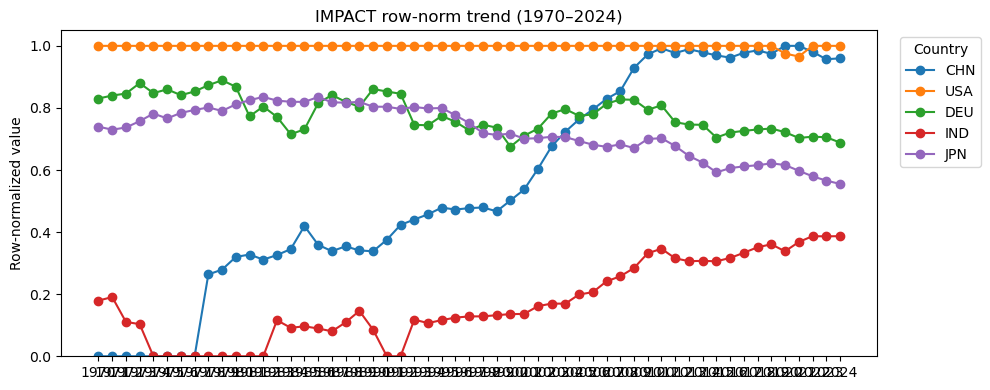

✓ saved: trend_pr_rownorm_1948_2024.png


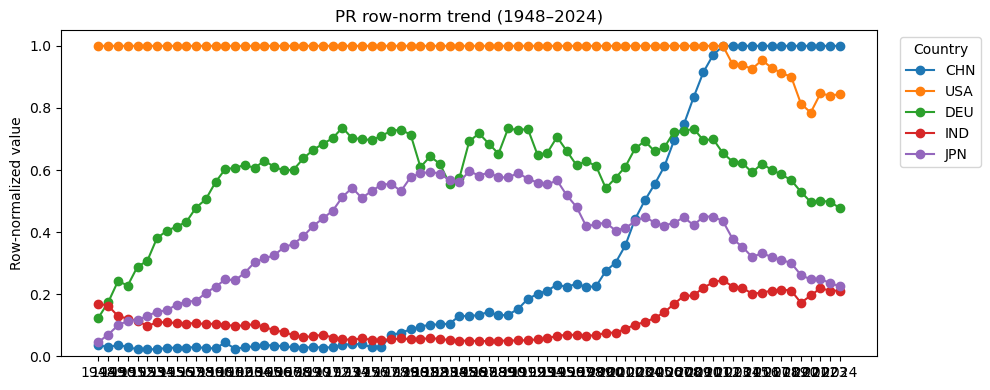

In [71]:
plot_country_trend(
    metric="impact",
    countries=["CHN", "USA", "DEU", "IND","JPN"],
    start_year=1970,
    end_year=2024,
    style="line"
)

plot_country_trend(
    metric="pr",
    countries=["CHN", "USA", "DEU", "IND","JPN"],
    start_year=1948,
    end_year=2024,
    style="line",
    save=True
)


In [ ]:
import ipywidgets as wd

country_multiselect = wd.SelectMultiple(options=sorted(ISO_VALID), value=("CHN","USA"))
metric_dd      = wd.Dropdown(options=["impact","eig","pr","bc"], value="impact")
year_slider    = wd.IntSlider(min=YEAR_START, max=YEAR_END, step=1, value=2020)
start_slider   = wd.IntSlider(min=YEAR_START, max=YEAR_END, value=2000, description="Start")
end_slider     = wd.IntSlider(min=YEAR_START, max=YEAR_END, value=2020, description="End")

@wd.interact(countries=country_multiselect, metric=metric_dd,
             single_year=year_slider, start=start_slider, end=end_slider)
def _viz(countries, metric, single_year, start, end):
    plt.clf()
    # 如果选择 single_year≥start -> 单年模式，否则用时间窗口
    if single_year >= start and single_year <= end:
        bar_compare_countries(list(countries), metric=metric, year=single_year)
    else:
        bar_compare_countries(list(countries), metric=metric,
                              start_year=start, end_year=end, year=None)


# 全局热力图绘制

<>:4: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:4: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\O'
C:\Users\12693\AppData\Local\Temp\ipykernel_23960\506169862.py:4: SyntaxWarning: invalid escape sequence '\O'
  DATA_SOURCE   = "E:\Obsidian\Project\专业课\大三下\Intro to Networks\Final_Essay\IMF_IMTS_Exports_1948_2024.csv"  # or dir of CSVs
C:\Users\12693\AppData\Local\Temp\ipykernel_23960\506169862.py:5: SyntaxWarning: invalid escape sequence '\O'
  COORD_CSV     = "E:\Obsidian\Project\专业课\大三下\Intro to Networks\Final_Essay\iso3_to_latlon.csv"
C:\Users\12693\AppData\Local\Temp\ipykernel_23960\506169862.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the groupi

✓ saved heatmap_eff_w_row_norm.png


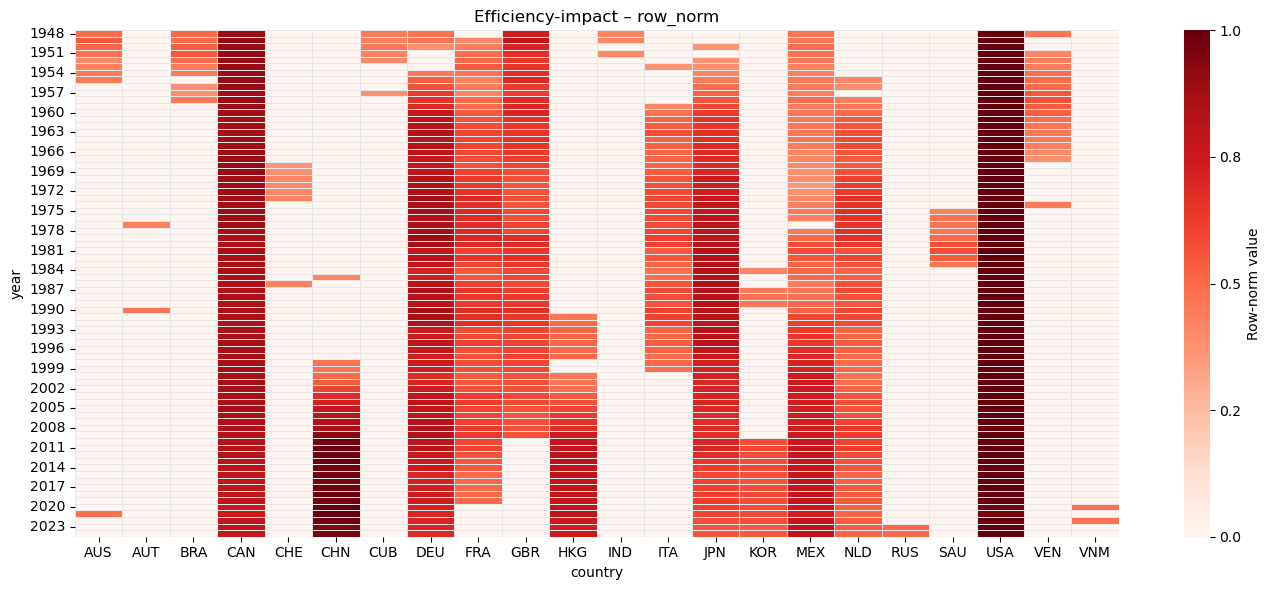

✓ saved heatmap_eig_row_norm.png


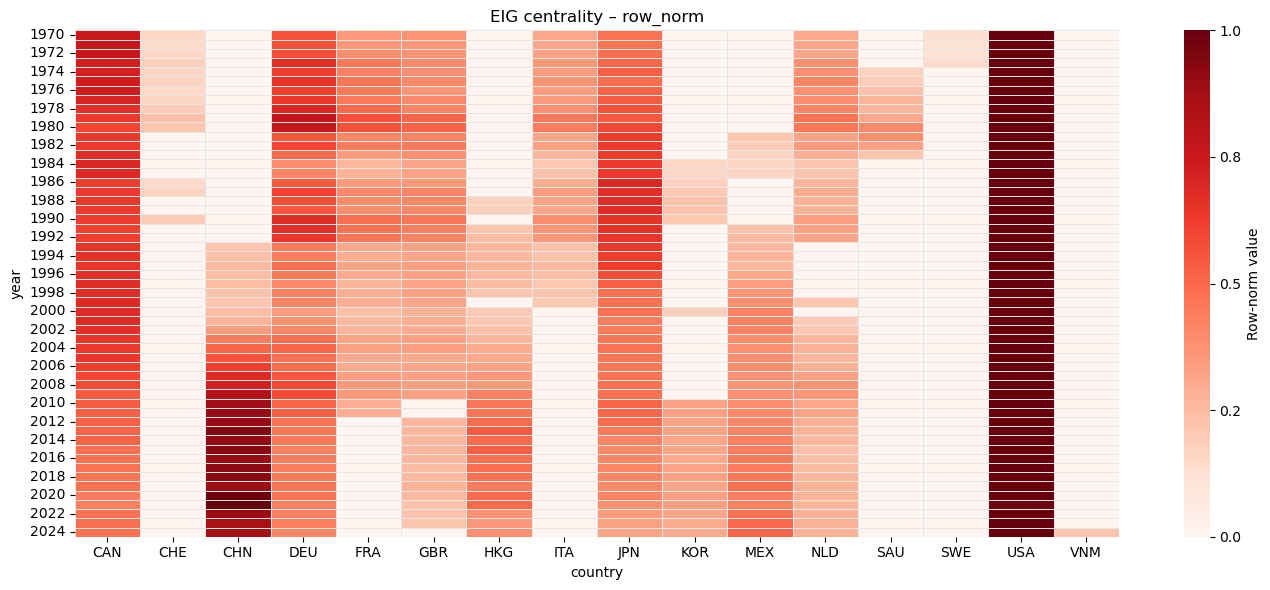

✓ saved heatmap_pr_row_norm.png


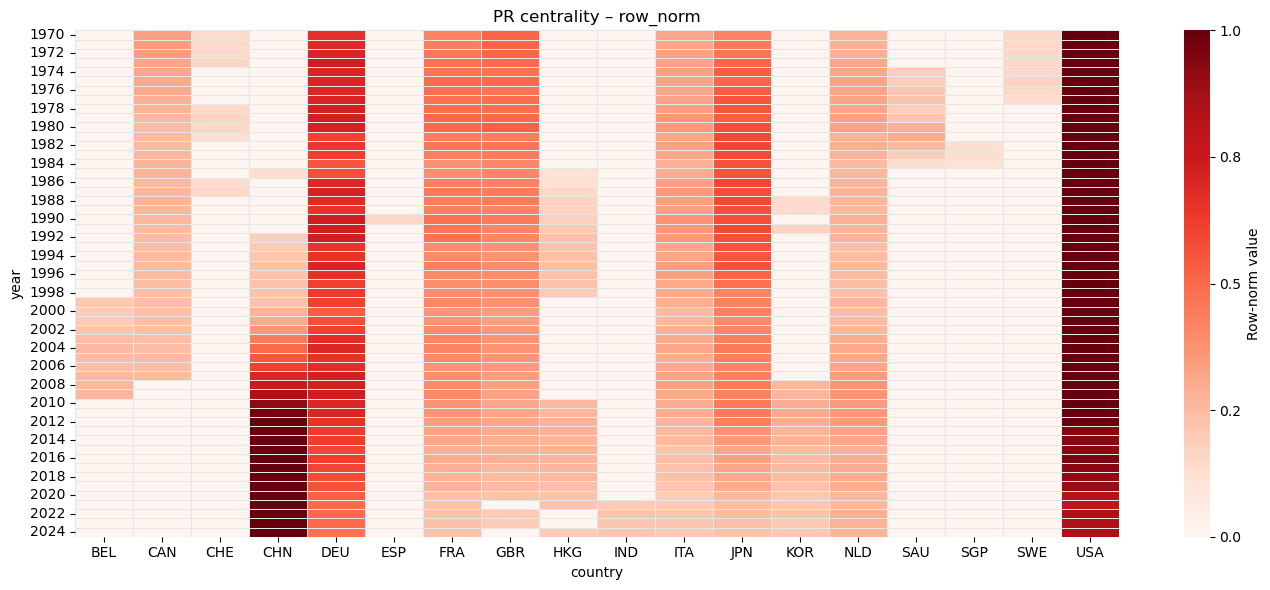

✓ saved heatmap_bc_row_norm.png


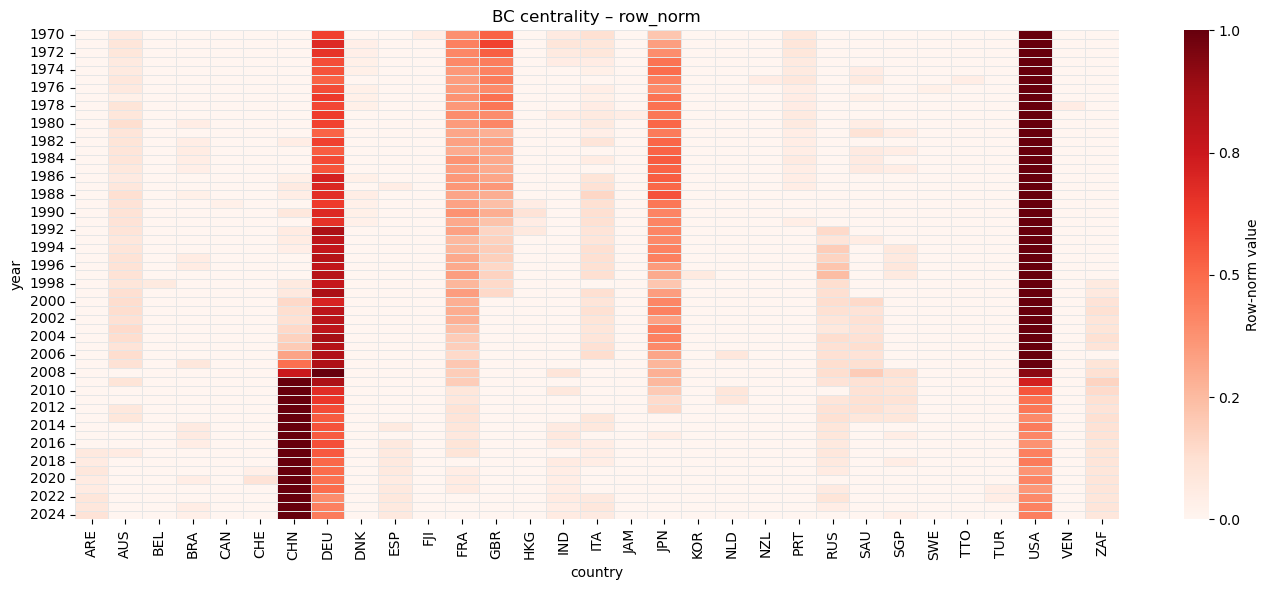

In [16]:
# ───────────────────────────────────────────────────────────────────────────
# CONFIG                                                                     
# ───────────────────────────────────────────────────────────────────────────
DATA_SOURCE   = "E:\Obsidian\Project\专业课\大三下\Intro to Networks\Final_Essay\IMF_IMTS_Exports_1948_2024.csv"  # or dir of CSVs
COORD_CSV     = "E:\Obsidian\Project\专业课\大三下\Intro to Networks\Final_Essay\iso3_to_latlon.csv"
YEAR_START    = 1970
YEAR_END      = 2024
IMPACT_TOP_N  = 20
THRESHOLD     = None
OUTPUT_DIR    = Path("outputs"); OUTPUT_DIR.mkdir(exist_ok=True)

# ──── user-tunable display settings ────────────────────────────────────────
HEATMAP_MODE  = "rank"       # "quantile" | "row_norm" | "rank"
GAMMA         = 0.4
Q_LOW, Q_HIGH = .05, .95
TOP_K_NODES   = 10
COLORMAP      = "Reds"


years = range(YEAR_START, YEAR_END+1)
modes = ["row_norm"]

# ① 加载单节点冲击数据
df_imp = pd.read_csv(OUTPUT_DIR / "node_impacts_eff_w_fast.csv")
pivot_imp = (df_imp
             .groupby("year").apply(lambda g: g.nlargest(TOP_K_NODES, "impact"))
             .droplevel(0)
             .pivot(index="year", columns="country", values="impact")
             .fillna(0))

# ② 遍历三种模式
for mode in modes:
    # ②-1 冲击热图
    draw_heatmap(pivot_imp,
                 mode=mode,
                 cmap=COLORMAP,
                 gamma=GAMMA, q_low=Q_LOW, q_high=Q_HIGH,
                 title=f"Efficiency-impact – {mode}",
                 fname=f"heatmap_eff_w_{mode}.png")

    # ②-2 三中心性热图
    for key in ["eig", "pr", "bc"]:
        yearly_centrality_heatmap(key, years,
                                  top_k=TOP_K_NODES,
                                  mode=mode)


<>:4: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:4: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\O'
C:\Users\12693\AppData\Local\Temp\ipykernel_37320\3852590455.py:4: SyntaxWarning: invalid escape sequence '\O'
  DATA_SOURCE   = "E:\Obsidian\Project\专业课\大三下\Intro to Networks\Final_Essay\IMF_IMTS_Exports_1948_2024.csv"  # or dir of CSVs
C:\Users\12693\AppData\Local\Temp\ipykernel_37320\3852590455.py:5: SyntaxWarning: invalid escape sequence '\O'
  COORD_CSV     = "E:\Obsidian\Project\专业课\大三下\Intro to Networks\Final_Essay\iso3_to_latlon.csv"
C:\Users\12693\AppData\Local\Temp\ipykernel_37320\3852590455.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the gro

✓ saved heatmap_eff_w_rank.png


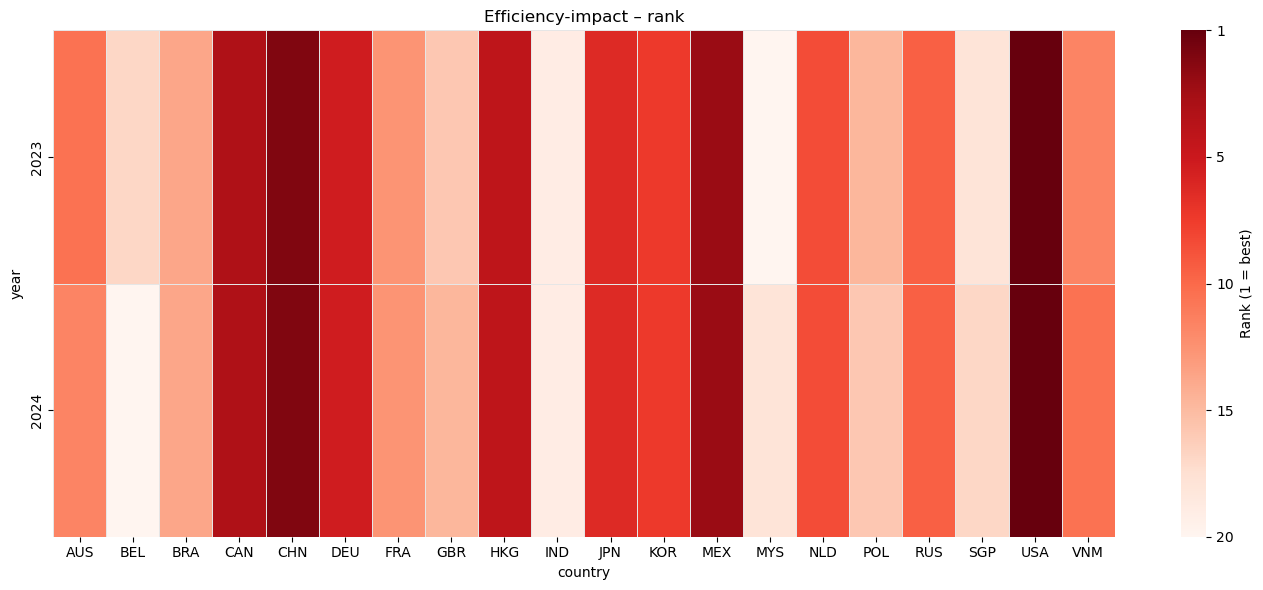

✓ saved heatmap_eig_rank.png


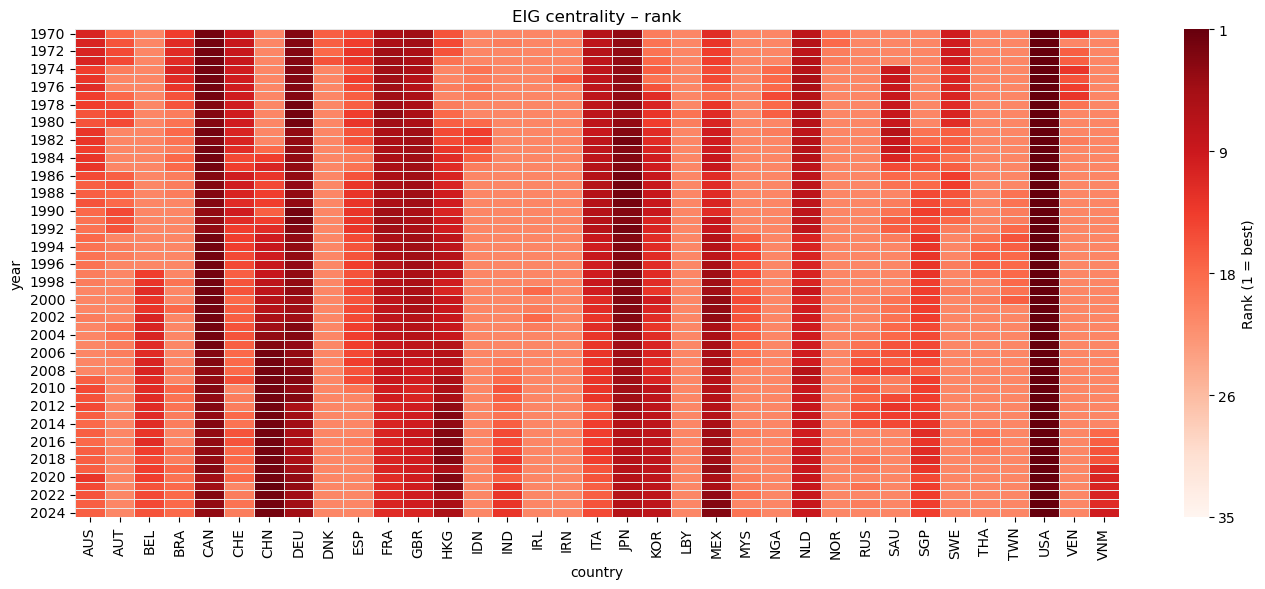

✓ saved heatmap_pr_rank.png


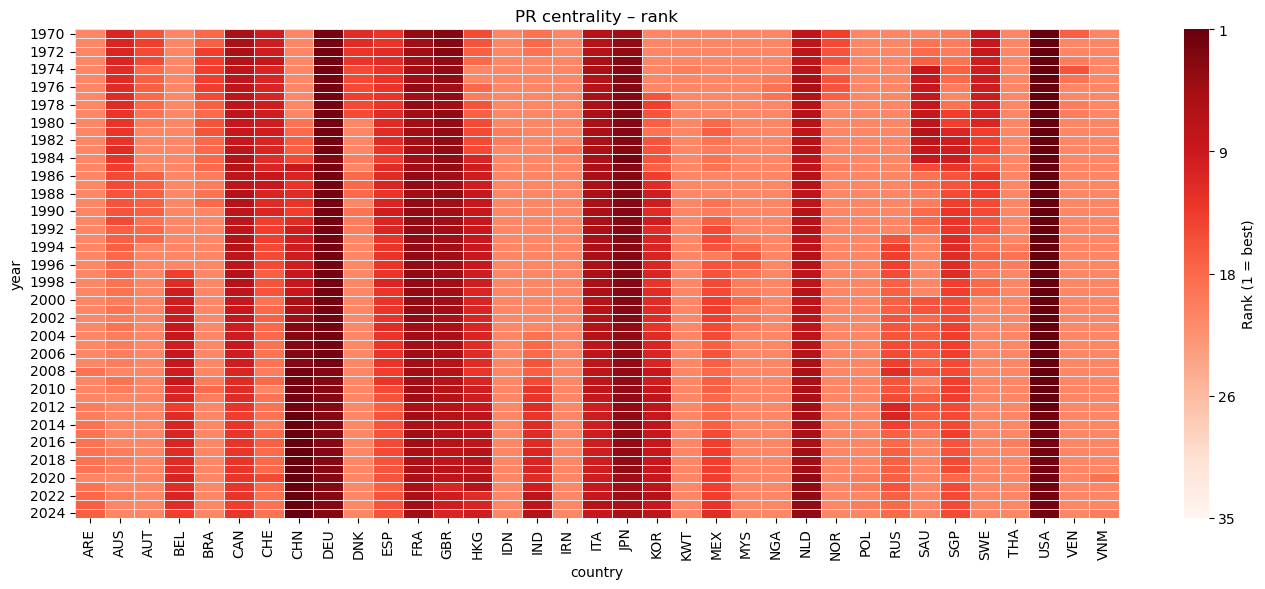

✓ saved heatmap_bc_rank.png


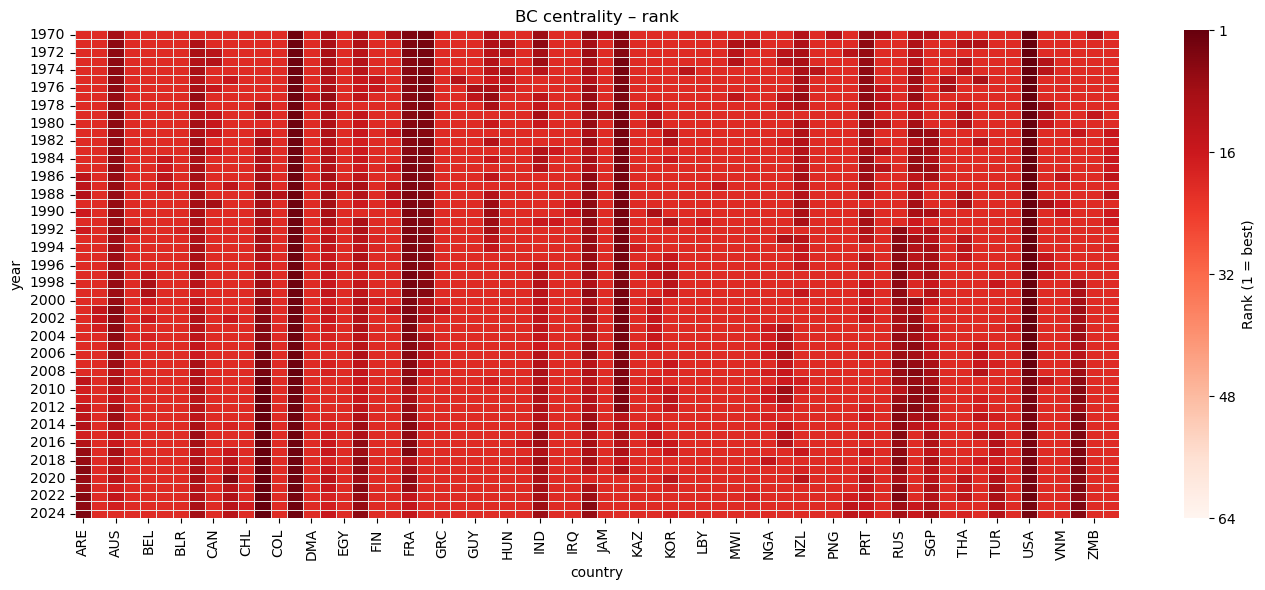

✓ saved heatmap_eff_w_row_norm.png


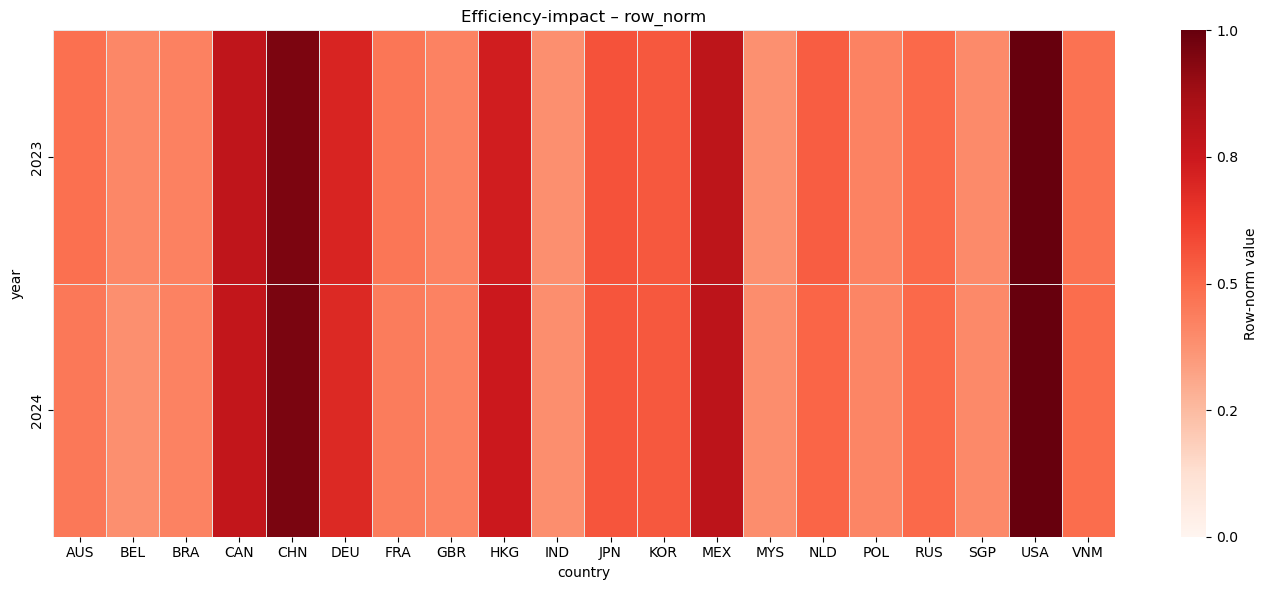

✓ saved heatmap_eig_row_norm.png


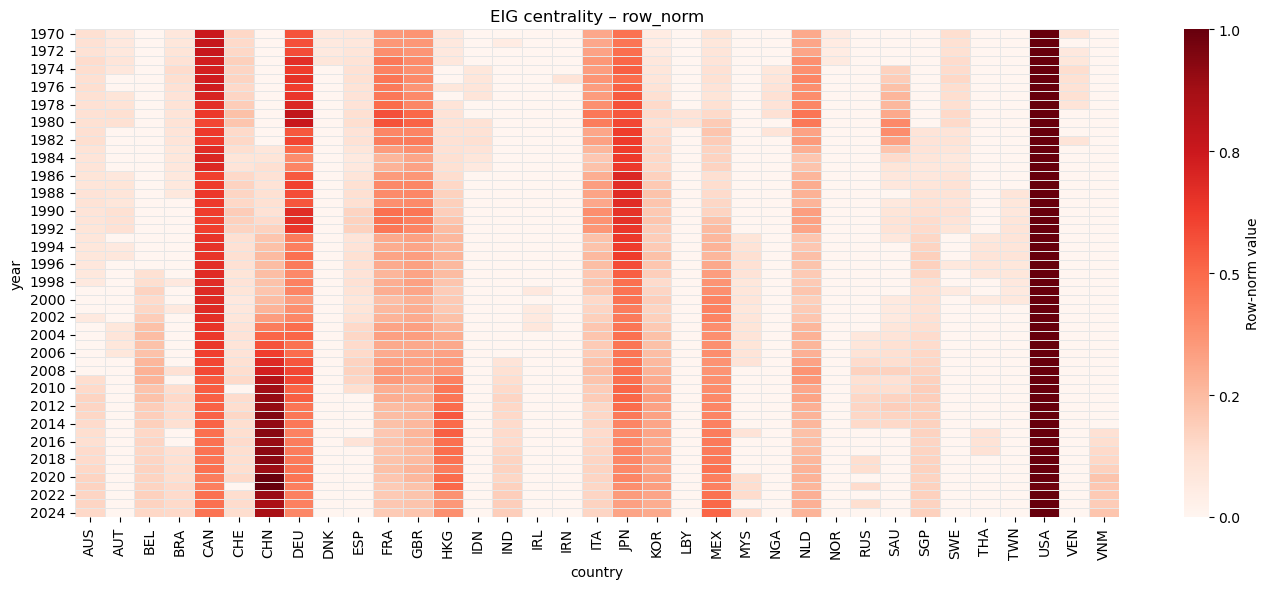

✓ saved heatmap_pr_row_norm.png


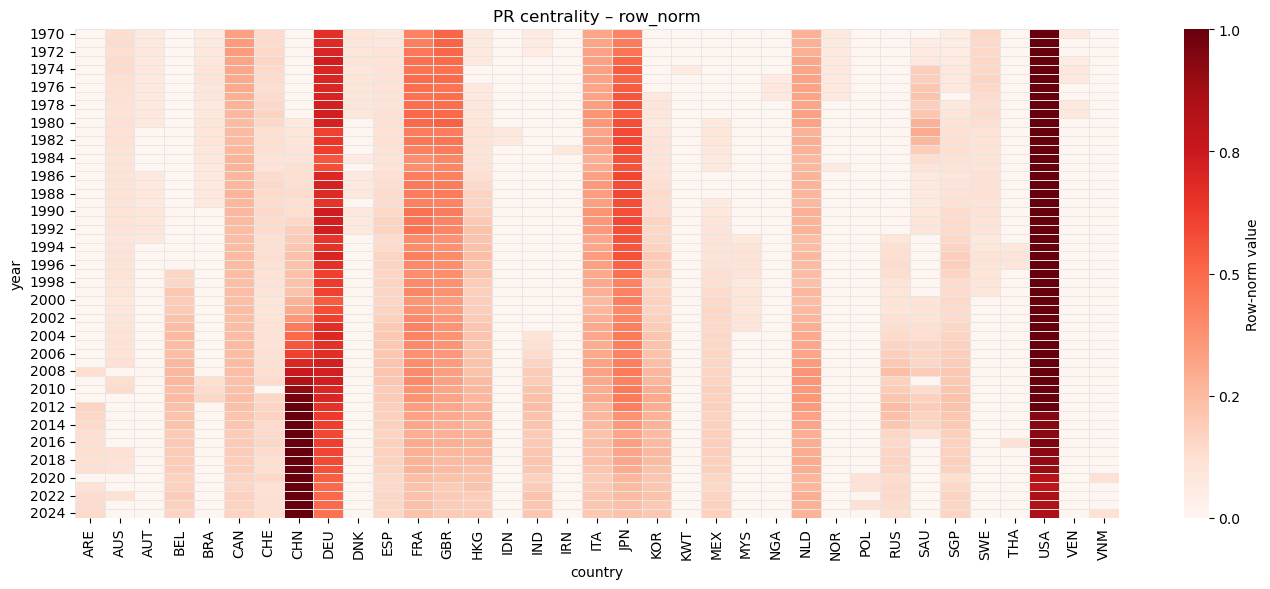

✓ saved heatmap_bc_row_norm.png


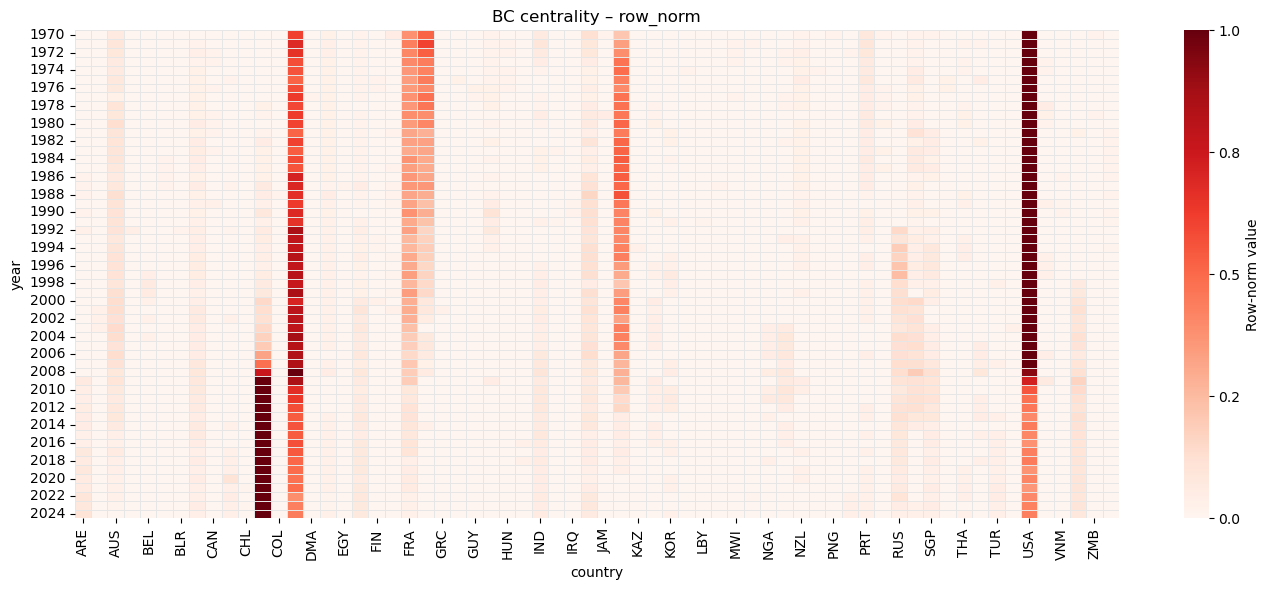

✓ saved heatmap_eff_w_quantile.png


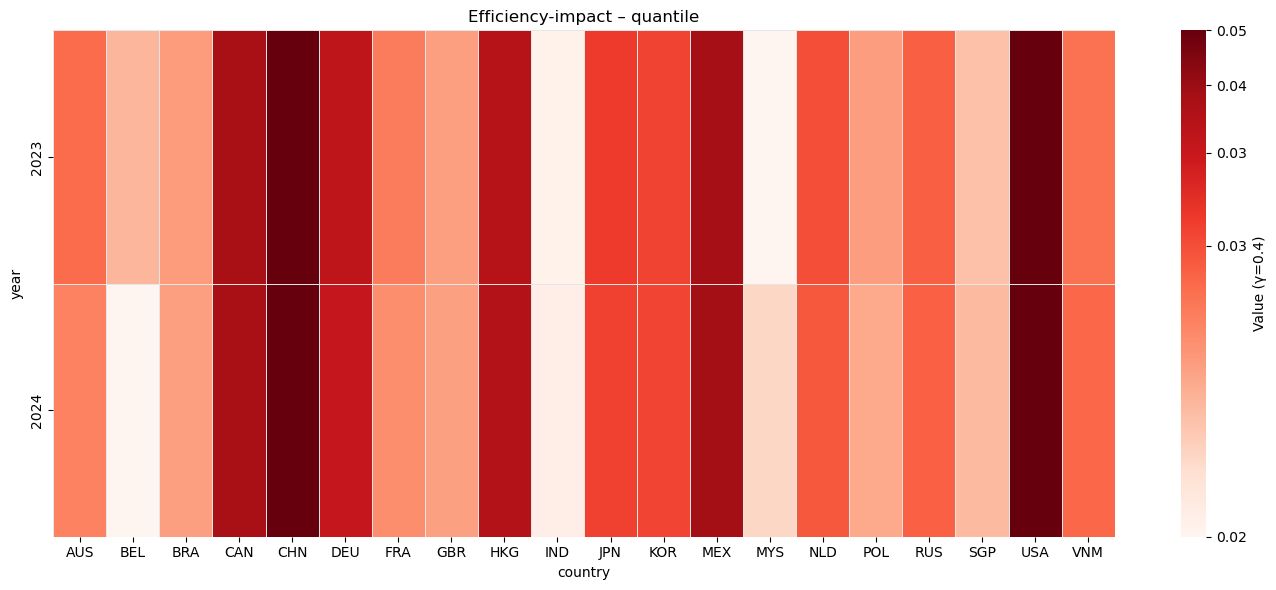

✓ saved heatmap_eig_quantile.png


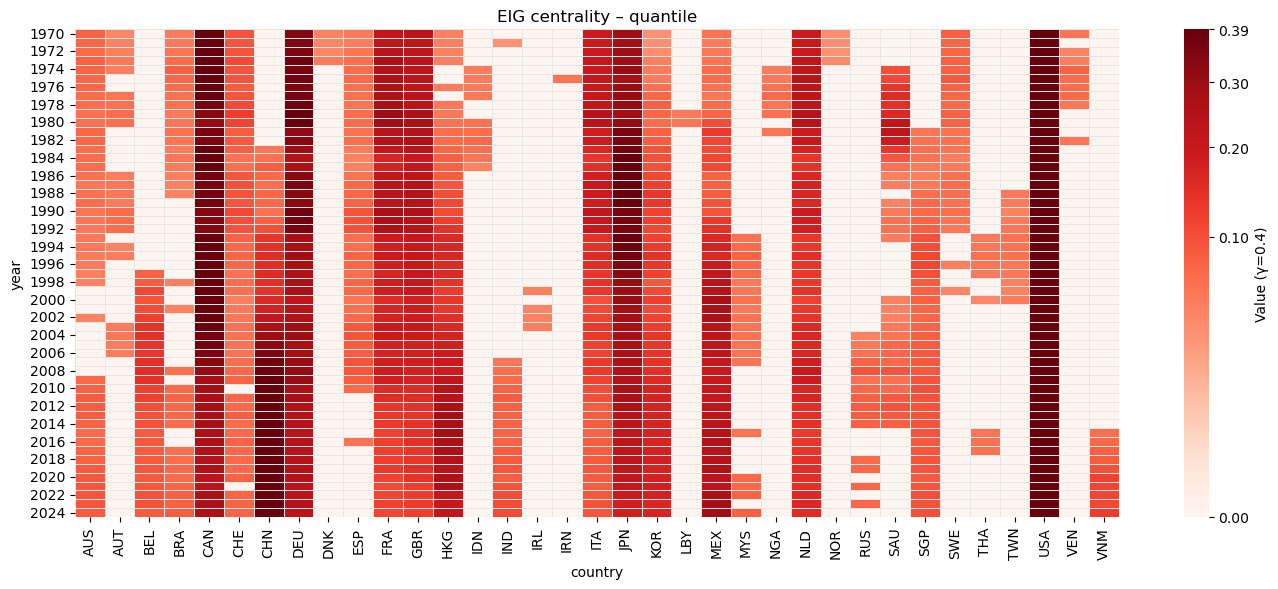

✓ saved heatmap_pr_quantile.png


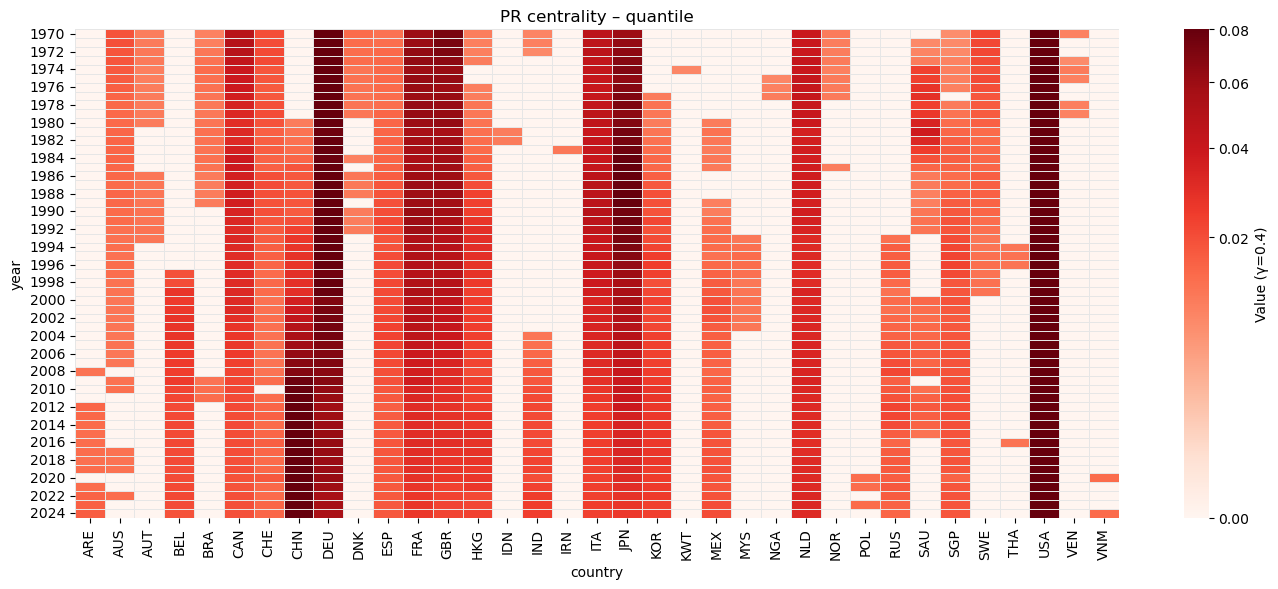

✓ saved heatmap_bc_quantile.png


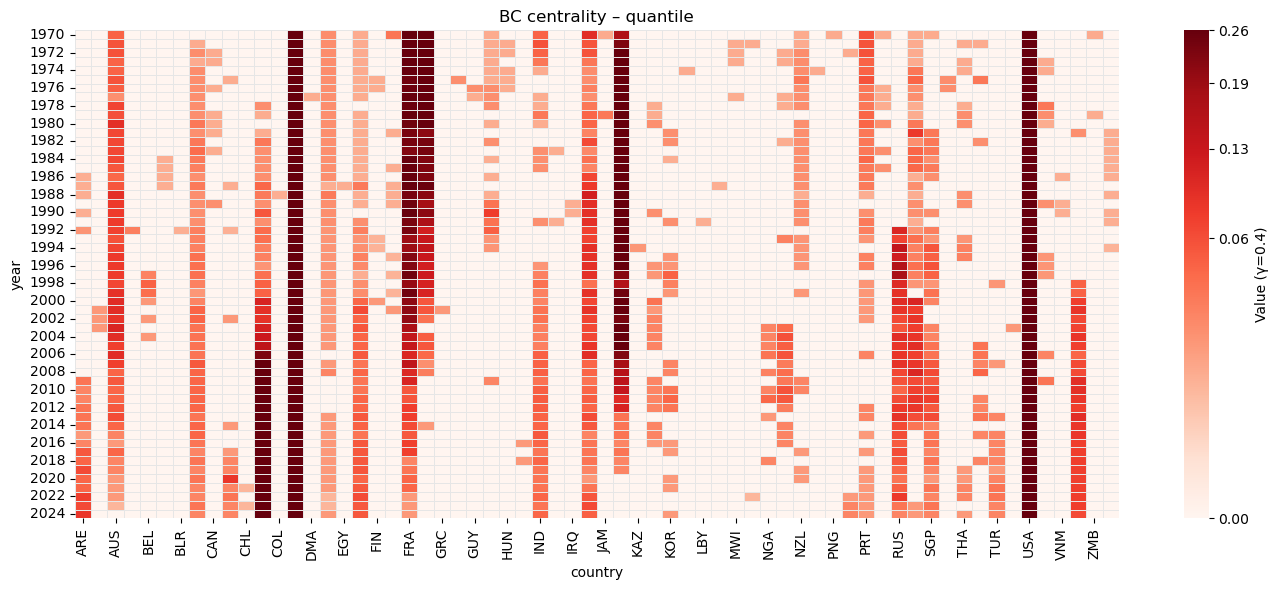

In [42]:
# ───────────────────────────────────────────────────────────────────────────
# CONFIG                                                                     
# ───────────────────────────────────────────────────────────────────────────
DATA_SOURCE   = "E:\Obsidian\Project\专业课\大三下\Intro to Networks\Final_Essay\IMF_IMTS_Exports_1948_2024.csv"  # or dir of CSVs
COORD_CSV     = "E:\Obsidian\Project\专业课\大三下\Intro to Networks\Final_Essay\iso3_to_latlon.csv"
YEAR_START    = 1970
YEAR_END      = 2024
IMPACT_TOP_N  = 50
THRESHOLD     = None
OUTPUT_DIR    = Path("outputs"); OUTPUT_DIR.mkdir(exist_ok=True)

# ──── user-tunable display settings ────────────────────────────────────────
HEATMAP_MODE  = "rank"       # "quantile" | "row_norm" | "rank"
GAMMA         = 0.4
Q_LOW, Q_HIGH = .05, .95
TOP_K_NODES   = 20
COLORMAP      = "Reds"


years = range(YEAR_START, YEAR_END+1)
modes = ["rank", "row_norm", "quantile"]

# ① 加载单节点冲击数据
df_imp = pd.read_csv(OUTPUT_DIR / "node_impacts_eff_w_fast.csv")
pivot_imp = (df_imp
             .groupby("year").apply(lambda g: g.nlargest(TOP_K_NODES, "impact"))
             .droplevel(0)
             .pivot(index="year", columns="country", values="impact")
             .fillna(0))

# ② 遍历三种模式
for mode in modes:
    # ②-1 冲击热图
    draw_heatmap(pivot_imp,
                 mode=mode,
                 cmap=COLORMAP,
                 gamma=GAMMA, q_low=Q_LOW, q_high=Q_HIGH,
                 title=f"Efficiency-impact – {mode}",
                 fname=f"heatmap_eff_w_{mode}.png")

    # ②-2 三中心性热图
    for key in ["eig", "pr", "bc"]:
        yearly_centrality_heatmap(key, years,
                                  top_k=TOP_K_NODES,
                                  mode=mode)
